In [1]:
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numpyro.distributions.util import validate_sample
import jax
from jax import random
from jax import numpy as jnp
import numpy as np
from numpy.lib.recfunctions import drop_fields, append_fields
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

In [2]:
jax.config.update("jax_enable_x64", True)

In [3]:
# numpyro.set_platform("cpu")

In [4]:
# numpyro.set_host_device_count(4)

# Prepare data

In [5]:
data = pd.read_csv("../datasets/model_dataset.csv")

# Drop missing values
data = data.dropna(subset="industry")
data = data.dropna(subset="occup")
data = data.dropna(subset="exp")
data = data.dropna(subset="salary")

# data = data.query("year == 1996")
data = data[['year','industry', 'occup', 'exp','salary',"sex",'elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','tenure','union','part_time',
                'public_sector','self_emp','age','firm_size','loc_size']].copy()

data.head(3)

,year,industry,occup,exp,salary,sex,elementary_edu,highschool_edu,postsec_edu,undergrad_edu,...,grad_college_refyear,grad_univ_refyear,tenure,union,part_time,public_sector,self_emp,age,firm_size,loc_size
0,1997,info/culture,other trades,5.0,78385.474860,0,0,0,1,0,...,0,0,55.0,0,0,0,0,26.0,1,1
1,1997,trade,clerical/supervisor,1.0,32225.139665,0,0,1,0,0,...,0,0,13.0,0,0,0,0,34.0,2,2
2,1997,utilities,operators/assemblers,12.0,62708.379888,0,0,0,0,1,...,0,0,138.0,1,0,1,0,34.0,3,3


In [6]:
#data.to_csv("../Numpyro/clean_dataset.csv", index=False)

# Dynamically update model

In [7]:
dataset = data.copy()

In [8]:
from GammaGLM import GammaGLM

In [9]:
gamma = GammaGLM("test", "pooled", dataset, "salary", ["exp","undergrad_edu"], "industry", ["exp","age","tenure"])
gamma

Model: test - Type: pooled - Dims: industry - Params: ['exp', 'undergrad_edu']

In [10]:
gamma.build()

I0000 00:00:1696392899.587138   53526 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


'Model test | pooled built'

In [11]:
gamma.run()

<class 'method'>


sample: 100%|██████████| 4000/4000 [00:53<00:00, 74.20it/s] 


AttributeError: 'GammaGLM' object has no attribute 'outputs_path'

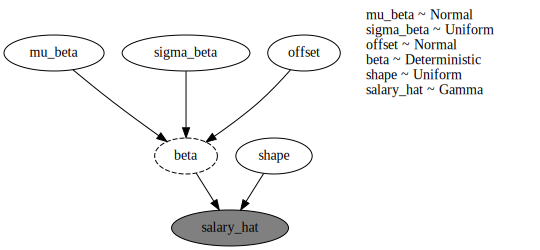

In [9]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

DISTRIBUTIONS = {
    "normal": dist.Normal,
    "half_normal": dist.HalfNormal,
    "student_t": dist.StudentT,
    "laplace": dist.Laplace,
    "uniform": dist.Uniform,
    "gamma": dist.Gamma,
    "lognormal": dist.LogNormal
}

def pooled(features, target, prior_dist="normal", prior_params={"loc": 0, "scale": 1}, shape_dist="uniform", shape_params={"low": 1, "high": 100}, target_dist="gamma"):
    beta = numpyro.sample("beta", DISTRIBUTIONS[prior_dist](**prior_params), sample_shape=(features.shape[1],))
    shape = numpyro.sample("shape", DISTRIBUTIONS[shape_dist](**shape_params))
    mu = jnp.exp(jnp.dot(features, beta))
    rate = shape / mu
    numpyro.sample("salary_hat", DISTRIBUTIONS[target_dist](concentration=shape, rate=rate), obs=target)

def hierarchical(features, target, industry, prior_dist="normal", prior_params={"loc": 0, "scale": 1}, shape_dist="uniform", shape_params={"low": 1, "high": 100}, target_dist="gamma"):
    mu_beta = numpyro.sample("mu_beta", DISTRIBUTIONS[prior_dist](**prior_params), sample_shape=(features.shape[1],))
    sigma_beta = numpyro.sample("sigma_beta", DISTRIBUTIONS[shape_dist](**shape_params), sample_shape=(features.shape[1],))
    offset = numpyro.sample("offset", DISTRIBUTIONS["normal"](loc=0, scale=1), sample_shape=(features.shape[1], industry.max()+1))
    beta = numpyro.deterministic("beta", mu_beta[:, None] + offset * sigma_beta[:, None])
    shape = numpyro.sample("shape", DISTRIBUTIONS[shape_dist](**shape_params))
    mu = jnp.exp(jnp.dot(features, beta[: ,industry]))
    rate = shape / mu
    numpyro.sample("salary_hat", DISTRIBUTIONS[target_dist](concentration=shape, rate=rate), obs=target)

numpyro.render_model(hierarchical, model_args=(features, target, industry), render_distributions=True)

In [35]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(hierarchical, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='vectorized', progress_bar=True)
mcmc.run(rng_key, features, target, industry)
trace = az.from_numpyro(mcmc)

I0000 00:00:1696342125.552477   12854 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
sample: 100%|██████████| 2000/2000 [1:00:21<00:00,  1.81s/it]
W0000 00:00:1696345751.428208   12854 hlo_rematerialization.cc:2946] Can't reduce memory use below 605.99MiB (635423346 bytes) by rematerialization; only reduced to 2.43GiB (2605067160 bytes), down from 2.43GiB (2605067224 bytes) originally
W0000 00:00:1696345752.263237   12854 hlo_rematerialization.cc:2946] Can't reduce memory use below -1.71GiB (-1836825006 bytes) by rematerialization; only reduced to 2.42GiB (2604416000 bytes), down from 2.42GiB (2604416000 bytes) originally
2023-10-03 11:09:22.279081: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.42GiB (rounded to 2604416000)requested by op 
2023-10-03 11:09:22.279212: W external/tsl/tsl/framework/bfc_allocator.cc:497] *************************************************************************************_______________

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2604416000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.42GiB
              constant allocation:         0B
        maybe_live_out allocation:    2.42GiB
     preallocated temp allocation:         0B
                 total allocation:    4.85GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.42GiB
		Entry Parameter Subshape: f64[4000,81388]
		==========================

	Buffer 2:
		Size: 2.42GiB
		XLA Label: fusion
		Shape: f64[4000,81388]
		==========================



In [14]:
import numpyro
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numpyro.distributions.util import validate_sample
import jax
from jax import random
from jax import numpy as jnp
import numpy as np
from numpy.lib.recfunctions import drop_fields, append_fields
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import datetime

jax.config.update("jax_enable_x64", True)

data = pd.read_csv("../datasets/model_dataset.csv")

# Drop missing values
data = data.dropna(subset="industry")
data = data.dropna(subset="occup")
data = data.dropna(subset="exp")
data = data.dropna(subset="salary")

# data = data.query("year == 1996")
data = data[['year','industry', 'occup', 'exp','salary',"sex",'elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','tenure','union','part_time',
                'public_sector','self_emp','age','firm_size','loc_size']].copy()

data.head(3)
dataset = data.copy()

dataset["exp"] = (dataset["exp"] - dataset["exp"].mean()) / dataset["exp"].std()
dataset["age"] = (dataset["age"] - dataset["age"].mean()) / dataset["age"].std()
dataset["tenure"] = (dataset["tenure"] - dataset["tenure"].mean()) / dataset["tenure"].std()

features = dataset[['exp','sex','elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu',
                'grad_highschool_refyear','grad_college_refyear','grad_univ_refyear','tenure','union','part_time',
                'public_sector','self_emp','age']].values
target = dataset['salary'].values
industry = pd.factorize(dataset['industry'])[0]

import jax
import jax.numpy as jnp
import numpyro
from numpyro import distributions as dist
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding

DISTRIBUTIONS = {
    "normal": dist.Normal,
    "half_normal": dist.HalfNormal,
    "student_t": dist.StudentT,
    "laplace": dist.Laplace,
    "uniform": dist.Uniform,
    "gamma": dist.Gamma,
    "lognormal": dist.LogNormal
}

def hierarchical(features, target, industry):
    mu_avg_salary = numpyro.sample("mu_avg_salary", dist.Normal(loc=0, scale=1))
    sigma_avg_salary = numpyro.sample("sigma_avg_salary", dist.HalfNormal(scale=1))
    mu_hyperpriors = [mu_avg_salary]
    sigma_hyperpriors = [sigma_avg_salary]
    for i in range(features.shape[1]):
        mu_hyperpriors.append(numpyro.sample(f"mu_{i}", dist.Normal(loc=0, scale=1)))
        sigma_hyperpriors.append(numpyro.sample(f"sigma_{i}", dist.HalfNormal(scale=1)))
    
    with numpyro.plate("industry", industry.max()+1):
        avg_salary = numpyro.sample("avg_salary", dist.Normal(loc=0, scale=1))
        priors = []
        for i in range(features.shape[1]):
            offset = numpyro.sample(f"offset_{i}", dist.Normal(loc=0, scale=1))
            prior = numpyro.deterministic(f"prior_{i}", mu_hyperpriors[i] + offset * sigma_hyperpriors[i])
            priors.append(prior)
    shape = numpyro.sample("shape", dist.Uniform(low=1, high=100))
    mu = avg_salary[industry]
    for i, prior in enumerate(priors):
        mu += prior[industry] * features[:,i]
    mu = jnp.exp(mu)
    rate = shape / mu
    with numpyro.plate("data", target.shape[0]):
        numpyro.sample("salary_hat", dist.Gamma(concentration=shape, rate=rate), obs=target)

numpyro.render_model(hierarchical, model_args=(features, target, industry), render_distributions=True)

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
# Run NUTS
kernel = NUTS(hierarchical, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='vectorized', progress_bar=True)
mcmc.run(rng_key, features, target, industry)







# Run NUTS
kernel = NUTS(hierarchical, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=10, num_samples=10, num_chains=4, chain_method='vectorized', progress_bar=True)
sharding = PositionalSharding(mesh_utils.create_device_mesh((2,)))
features_shard = jax.device_put(features, sharding.reshape(2, 1))
target_shard = jax.device_put(target, sharding.reshape(2))
industry_shard = jax.device_put(industry, sharding.reshape(2))
mcmc.run(jax.random.PRNGKey(0), features_shard, target_shard, industry_shard)







warmup:   7%|▋         | 140/2000 [15:09<9:03:59, 17.55s/it] 

In [13]:
az.summary(az.from_numpyro(mcmc), var_names=["avg_salary","prior"], filter_vars="like")

W0000 00:00:1696352770.200046   34398 hlo_rematerialization.cc:2946] Can't reduce memory use below 607.84MiB (637370193 bytes) by rematerialization; only reduced to 1.21GiB (1302208000 bytes), down from 1.21GiB (1302208000 bytes) originally
W0000 00:00:1696352770.216565   34398 hlo_rematerialization.cc:2946] Can't reduce memory use below 607.84MiB (637370193 bytes) by rematerialization; only reduced to 1.21GiB (1302208000 bytes), down from 1.21GiB (1302208000 bytes) originally
2023-10-03 13:06:20.226461: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.21GiB (rounded to 1302208000)requested by op 
2023-10-03 13:06:20.227476: W external/tsl/tsl/framework/bfc_allocator.cc:497] ***************************************************************************************_____________
2023-10-03 13:06:20.227599: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2644] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memor

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1302208000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    1.21GiB
              constant allocation:         0B
        maybe_live_out allocation:    1.21GiB
     preallocated temp allocation:         0B
                 total allocation:    2.42GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 1.21GiB
		Entry Parameter Subshape: f64[2000,81388]
		==========================

	Buffer 2:
		Size: 1.21GiB
		XLA Label: fusion
		Shape: f64[2,1000,81388]
		==========================



In [13]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(pooled, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=10, num_samples=10, num_chains=4, chain_method='vectorized', progress_bar=True)
sharding = PositionalSharding(mesh_utils.create_device_mesh((2,)))
features_shard = jax.device_put(features, sharding.reshape(2, 1))
target_shard = jax.device_put(target, sharding.reshape(2))
mcmc.run(jax.random.PRNGKey(0), features_shard, target_shard)

sample: 100%|██████████| 200/200 [02:32<00:00,  1.31it/s]


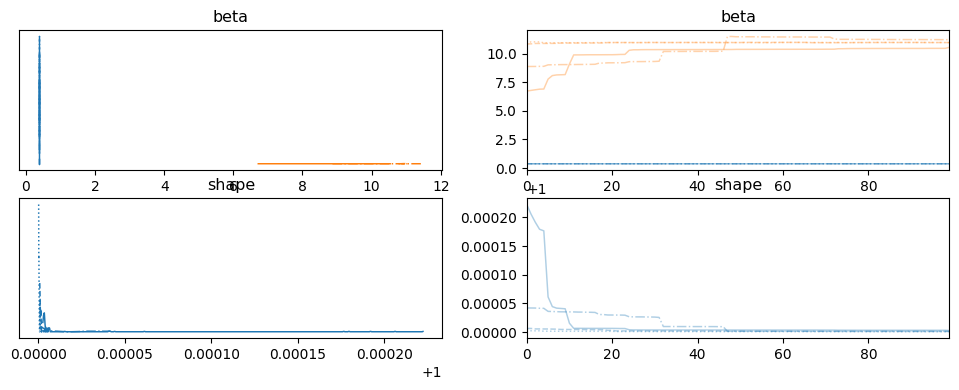

In [12]:
az.plot_trace(trace); 

In [33]:
import jax
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

X = np.random.randn(128, 3)
y = np.random.randn(128)

def model(X, y):
    beta = numpyro.sample("beta", dist.Normal(0, 1), sample_shape=(X.shape[1],))
    numpyro.sample("obs", dist.Normal(X @ beta, 1), obs=y)

mcmc = MCMC(NUTS(model), num_warmup=10000, num_samples=10000)
sharding = PositionalSharding(mesh_utils.create_device_mesh((2,)))
X_shard = jax.device_put(X, sharding.reshape(2, 1))
y_shard = jax.device_put(y, sharding.reshape(2))
mcmc.run(jax.random.PRNGKey(0), X_shard, y_shard)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [7]:
class CustomKDEDistribution(dist.Distribution):
    
    def __init__(self, data, validate_args=False):
        data = np.array(data).flatten()
        self.kde = gaussian_kde(data)  
        self.x_points = np.linspace(np.min(data) - 1, np.max(data) + 1, 100000)
        self.pdf_estimated = self.kde.evaluate(self.x_points)  
        self.cdf_estimated = jnp.cumsum(self.pdf_estimated) / jnp.sum(self.pdf_estimated) # Normalized
        self._batch_shape = ()
        self.support = dist.constraints.real
        super(CustomKDEDistribution, self).__init__(batch_shape=self._batch_shape, validate_args=validate_args)

    def sample(self, key, sample_shape=()):
        # Generating samples using inverse transform sampling
        uniform_samples = random.uniform(key, sample_shape + self._batch_shape)
        samples = jnp.interp(uniform_samples, self.cdf_estimated, self.x_points)
        return samples

    def log_prob(self, value):
        # Validating the input sample
        validate_sample(value)
        
        # Getting the log probability using the KDE estimated PDF
        # Use linear interpolation to get the PDF values at the given points
        pdf_values_at_value = jnp.interp(value, self.x_points, self.pdf_estimated)
        log_prob = jnp.log(pdf_values_at_value)
        return log_prob

NOTE: This class is an implementation (in progress) of the online learning process

In [8]:
class GammaGML():
    def __init__(self, name, parameters, target_var, dataset, year=None, standardize_vars=[], online_learning=False):
        self.name = name
        self.target = target_var
        self.priors = {
            "normal": dist.Normal,
            "uniform": dist.Uniform,
            "beta": dist.Beta,
            "gamma": dist.Gamma,
            "poisson": dist.Poisson,
            "student_t": dist.StudentT,
            "halfnormal": dist.HalfNormal,
            "halfcauchy": dist.HalfCauchy,
            "exponential": dist.Exponential,
            "laplace": dist.Laplace}
        self.vars = {}
        self.dimensions = []
        self.year = year
        self.online_learning = online_learning

        self.get_var_dims(parameters)
        self.data_processing(dataset, standardize_vars, year)
        self.get_plates()
        self.get_coords_dims()

    def __repr__(self):
        if self.year is not None:
            return f"Model: {self.name} - params: {list(self.vars.keys())} - year: {self.year}"
        else:
            return f"Model: {self.name} - params: {list(self.vars.keys())}"
    
    def standardize_var(self, variable):
        variable = (variable - variable.mean()) / variable.std()
        return variable

    def get_var_dims(self, parameters):
        # Create vars and dimensions attributes
        for var, params in parameters.items():
            self.vars[var] = params

            if params.get("dims") is not None:
                self.dimensions += [ dim for dim in params.get("dims") if dim not in self.dimensions ]

    def get_coords_dims(self):
        # Get coords and dims attributes for Arviz
        coords = { coord[0]: list(coord[1]) for coord in self.dimensions }
        dims = {}
        for var in self.vars.keys():
            if self.vars[var]["type"] == "intercept":
                var_name = f"{var}"
            elif self.vars[var]["type"] == "slope":
                var_name = f"beta_{var}"

            if self.vars[var]["dims"] is not None:
                dims[var_name] = [f"{dim}" for dim in self.vars[var]["dims"]]
        
        self.coords = coords
        self.dims = dims

    def data_processing(self, dataset, standardize_vars, year):
        # Data processing
        self.dataset = dataset.to_records(index=False)
        if year is not None:
            if 'year' in self.dataset.dtype.names:
                self.dataset = self.dataset[self.dataset["year"] == year]
                self.dataset = drop_fields(self.dataset, "year")
            else:
                raise ValueError("year is not a column in the dataset")
            
        for var in standardize_vars:
            self.dataset[var] = self.standardize_var(self.dataset[var])

        for var_id, var  in enumerate(self.dimensions):
            coord, coord_idx = np.unique(self.dataset[var], return_inverse=True)
            self.dimensions[var_id] = (var, coord)
            self.dataset = drop_fields(self.dataset, var)
            self.dataset = append_fields(self.dataset, var, coord_idx, usemask=False)

    def get_prior_name(self, var):
        # Prior name
        if self.vars[var]["type"] == "intercept":
            prior_name = f"{var}"
        elif self.vars[var]["type"] == "slope":
            prior_name = f"beta_{var}"
        else:
            prior_name = f"{var}"
        return prior_name
    
    def get_dist_params(self, var, prior_name, last_trace=None):
        if self.vars[var]["hyperprior"]:
            dist_params = self.build_hyperprior(var, prior_name)
        elif self.vars[var]["dist"] == "custom":
            dist_params = last_trace.posterior[prior_name].values
        else:
            dist_params = self.vars[var]["initial_values"]
        return dist_params

    def get_plates(self):
        # Create plates
        self.plates = {}
        self.plates[None] = {"vars": [ var for var, params in self.vars.items() if params["dims"] is None ]}
        for dim, dim_categories in self.dimensions:
            self.plates[dim] = {"vars": [ var for var, params in self.vars.items() if dim in list(params["dims"] if params["dims"] is not None else []) ]}
            self.plates[dim]["dimensions"] = dim_categories
    
    def build_hyperprior(self, var, prior_name):
        hyperpriors = {}
        if self.vars[var]["dist"] == "laplace":
            lambda_class = self.priors["halfcauchy"]
            lambda_prior = lambda_class(scale=10)
            lambda_dist = numpyro.sample(name = f"lambda_{prior_name}", fn = lambda_prior)
            hyperpriors["loc"] = 0
            hyperpriors["scale"] = lambda_dist
        else:
            mu_class = self.priors["normal"]
            sigma_class = self.priors["halfnormal"]
            mu_prior = mu_class(**self.vars[var]["initial_values"])
            sigma_prior = sigma_class(scale=1)

            mu = numpyro.sample(name = f"mu_{prior_name}", fn = mu_prior)
            sigma = numpyro.sample(name = f"sigma_{prior_name}", fn = sigma_prior)
            hyperpriors["loc"] = mu
            hyperpriors["scale"] = sigma

        return hyperpriors

    def build_prior(self, var, prior_name, dist_params):
        distribution_class = self.priors[self.vars[var]["dist"]]
        if self.vars[var]["dist"] == "custom":
            distribution = distribution_class(data=dist_params)
        else:
            distribution = distribution_class(**dist_params)

        if self.vars[var]["parameterization"] == "non-centered-affine":
            prior = numpyro.sample(name = prior_name,
                                fn = dist.TransformedDistribution(dist.Normal(loc=0, scale=1),
                                                                    dist.transforms.AffineTransform(**dist_params)))
        elif self.vars[var]["parameterization"] == "non-centered":
            offset = numpyro.sample(name = f"offset_{prior_name}", fn = dist.Normal(loc=0, scale=1))
            prior = numpyro.deterministic(f"{prior_name}", dist_params["loc"] + offset * dist_params["scale"])
        else:
            prior = numpyro.sample(name = prior_name, fn = distribution)
        return prior

    def build(self, last_trace=None):
        def model():
            # Add prior names
            for plate, plate_config in self.plates.items():
                self.plates[plate]["prior_names"] = []
                for var in plate_config["vars"]:
                    prior_name = self.get_prior_name(var)
                    self.plates[plate]["prior_names"].append(prior_name)

            # Add distribution parameters (or hyperpriors)
            for plate, plate_config in self.plates.items():
                self.plates[plate]["dist_params"] = []
                for var in plate_config["vars"]:
                    dist_params = self.get_dist_params(var, plate_config["prior_names"][plate_config["vars"].index(var)], last_trace)
                    self.plates[plate]["dist_params"].append(dist_params)
                    
            # Priors
            mu = 0
            for plate, plate_config in self.plates.items():
                if plate is None:
                    for var in plate_config["vars"]:
                        prior_name = plate_config["prior_names"][plate_config["vars"].index(var)]
                        dist_params = plate_config["dist_params"][plate_config["vars"].index(var)]
                        # Priors  
                        if var == "shape":
                            shape = self.build_prior(var, prior_name, dist_params)
                        elif self.vars[var]["type"] == "intercept":
                            prior = self.build_prior(var, prior_name, dist_params)
                            mu += prior
                        else:
                            prior = self.build_prior(var, prior_name, dist_params)
                            mu += prior * self.dataset[var]
                        
                else:
                     # Hyperpriors should be outside the plate
                    with numpyro.plate(plate, len(plate_config["dimensions"])):
                        for var in plate_config["vars"]:
                            prior_name = plate_config["prior_names"][plate_config["vars"].index(var)]
                            dist_params = plate_config["dist_params"][plate_config["vars"].index(var)]
                            if self.vars[var]["type"] == "intercept":
                                prior = self.build_prior(var, prior_name, dist_params)
                                mu += prior[self.dataset[plate]]
                            else:
                                prior = self.build_prior(var, prior_name, dist_params)
                                mu += prior[self.dataset[plate]] * self.dataset[var]
                                
            mu = jnp.exp(mu)
            rate = shape / mu    

            with numpyro.plate("data", len(self.dataset)):
                likelihood = numpyro.sample(self.target, dist.Gamma(concentration=shape, rate=rate), obs=self.dataset[self.target])

        return model
    
    def add_unconstrained_vars(self, trace):
        for var in trace.posterior.data_vars:
            if var not in ['shape']:
                new_var_name = f"{var}_unconstrained"
                trace.posterior = trace.posterior.assign({new_var_name: np.exp(trace.posterior[var])})
        return trace

    def run_model(self, model, draws=4000, warmup=4000, chains=4, target_accept_prob=0.95, progress_bar=True):
        # Start from this source of randomness. We will split keys for subsequent operations.
        rng_key = random.PRNGKey(0)
        rng_key, rng_key_ = random.split(rng_key)

        # Run NUTS
        kernel = NUTS(model, target_accept_prob=target_accept_prob)
        mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', progress_bar=progress_bar)
        mcmc.run(rng_key)
        trace = az.from_numpyro(mcmc, coords=self.coords, dims=self.dims)
        trace = self.add_unconstrained_vars(trace)
        return mcmc

In [9]:
params = {
    'avg_salary_ind': {"type": "intercept", "dist": "normal", "initial_values": {"loc": 0, "scale": 1}, "dims": ["industry"], "hyperprior": False, "parameterization": "centered"},
    'exp': {"type": "slope", "dist": "normal", "initial_values": {"loc": 0, "scale": 1}, "dims": ["industry"], "hyperprior": False, "parameterization": "centered"},
    'shape': {"type": "shape", "dist": "uniform", "initial_values": {"low": 0, "high": 100}, "dims": None, "hyperprior": False, "parameterization": "centered"}
}

gamma = GammaGML('test', dataset=dataset, parameters=params, target_var="salary", standardize_vars=["exp","age","tenure"], year=2010)
gamma

Model: test - params: ['avg_salary_ind', 'exp', 'shape'] - year: 2010

In [10]:
model = gamma.build()

In [11]:
# mcmc = gamma.run_model(model, warmup=10, draws=10)

In [12]:
import jax
from jax.experimental import mesh_utils
from jax.sharding import PositionalSharding
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [13]:
dataset = dataset.loc[dataset.index[:-4]].copy()

In [14]:
dataset["exp"] = (dataset["exp"] - dataset["exp"].mean()) / dataset["exp"].std()
dataset["age"] = (dataset["age"] - dataset["age"].mean()) / dataset["age"].std()
dataset["tenure"] = (dataset["tenure"] - dataset["tenure"].mean()) / dataset["tenure"].std()

In [15]:
X = dataset[["exp", "elementary_edu", "highschool_edu", "postsec_edu", "undergrad_edu", "graduate_edu",
         "grad_highschool_refyear", "grad_college_refyear", "grad_univ_refyear", "tenure", "union", "part_time",
         "public_sector", "self_emp", "age"]].values
y = dataset["salary"].values


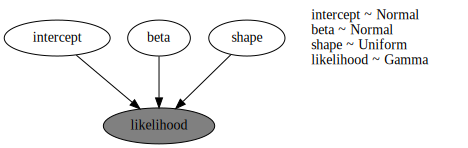

In [17]:
def test(X, y):
    intercept = numpyro.sample("intercept", dist.Normal(10, 1))
    beta = numpyro.sample("beta", dist.Normal(0, 1).expand([15]))
    shape = numpyro.sample("shape", dist.Uniform(1, 100))

    mu = jnp.exp(X @ beta + intercept)
    rate = shape / mu

    likelihood = numpyro.sample("likelihood", dist.Gamma(concentration=shape, rate=rate), obs=y)

numpyro.render_model(test,render_distributions=True, model_args=(X, y))

In [18]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=2000, num_chains=4, progress_bar=True)
# mcmc.run(rng_key)
sharding = PositionalSharding(mesh_utils.create_device_mesh((8,)))
X_shard = jax.device_put(X, sharding.reshape(8, 1))
y_shard = jax.device_put(y, sharding.reshape(8))
mcmc.run(jax.random.PRNGKey(0), X_shard, y_shard)

I0000 00:00:1696096532.515648   25298 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2023-09-30 13:55:32.520295: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:276] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [17]:
az.summary(az.from_numpyro(mcmc))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.005,0.867,-1.449,0.832,0.433,0.331,4.0,4.0,5.877474e+15
beta[1],-0.854,0.767,-1.829,0.260,0.382,0.293,4.0,4.0,5.877474e+15
beta[2],-0.037,1.281,-1.699,1.268,0.639,0.490,4.0,4.0,5.877474e+15
beta[3],0.123,0.969,-1.291,1.440,0.484,0.370,4.0,4.0,5.341631e+15
beta[4],0.163,1.000,-0.832,1.790,0.499,0.382,4.0,4.0,5.877474e+15
beta[5],-0.389,1.085,-1.224,1.470,0.542,0.415,4.0,4.0,5.877474e+15
beta[6],-0.639,0.793,-1.890,0.313,0.396,0.303,4.0,4.0,5.341631e+15
beta[7],-0.275,0.790,-1.043,0.925,0.394,0.302,4.0,4.0,5.877474e+15
beta[8],0.544,0.826,-0.673,1.659,0.412,0.316,4.0,4.0,5.341631e+15
beta[9],0.028,0.096,-0.131,0.127,0.048,0.037,4.0,4.0,5.877474e+15


In [45]:
with open(r"mcmc_model.pickle", "wb") as output_file:
    pickle.dump(mcmc, output_file)

In [27]:
mcmc.get_samples()['avg_salary_ind'].shape

(400,)

In [28]:
trace = az.from_numpyro(mcmc)
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [33]:
mcmc.__dict__.keys()

dict_keys(['sampler', '_sample_field', '_default_fields', 'num_warmup', 'num_samples', 'num_chains', 'thinning', 'postprocess_fn', 'chain_method', 'progress_bar', '_jit_model_args', '_states', '_states_flat', '_last_state', '_warmup_state', '_init_state_cache', '_cache', '_collection_params', '_args', '_kwargs'])

In [34]:
mcmc.__dict__['num_samples']

10

In [35]:
mcmc.get_samples(group_by_chain=True)

{'age': Array([[ 1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.100

In [36]:
mcmc.post_warmup_state = mcmc.last_state
mcmc.run(mcmc.post_warmup_state.rng_key)

sample: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


In [37]:
mcmc.get_samples(group_by_chain=True)

{'age': Array([[ 1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492,
          1.1001492,  1.1001492,  1.1001492,  1.1001492,  1.1001492],
        [-1.2464536, -1.2464536, -1.2464536, -1.2464536, -1.2464536,
         -1.2464536, -1.2464536, -1.2464536, -1.2464536, -1.2464536],
        [-0.9462185, -0.9462185, -0.9462185, -0.9462185, -0.9462185,
         -0.9462185, -0.9462185, -0.9462185, -0.9462185, -0.9462185],
        [-1.3384836, -1.3384836, -1.3384836, -1.3384836, -1.3384836,
         -1.3384836, -1.3384836, -1.3384836, -1.3384836, -1.3384836]],      dtype=float32),
 'avg_salary_ind': Array([[-0.11900992, -0.11900992, -0.11900992, -0.11900992, -0.11900992,
         -0.11900992, -0.11900992, -0.11900992, -0.11900992, -0.11900992],
        [-1.060695  , -1.060695  , -1.060695  , -1.060695  , -1.060695  ,
         -1.060695  , -1.060695  , -1.060695  , -1.060695  , -1.060695  ],
        [-1.2875072 , -1.2875072 , -1.2875072 , -1.2875072 , -1.2875072 ,
         -1.2875072 , -1.

In [38]:
mcmc.num_samples = 20

In [39]:
mcmc.run(mcmc.post_warmup_state.rng_key)

sample: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


In [40]:
mcmc.get_samples()["avg_salary_ind"].shape

(80,)

In [41]:
az.from_numpyro(mcmc)

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [58]:
mcmc.sampler

In [274]:
az.summary(mcmc)``

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_salary_ind[accommodation and food services],10.557,0.067,10.436,10.690,0.001,0.000,11736.0,6711.0,1.0
avg_salary_ind[agriculture],10.549,0.101,10.354,10.732,0.001,0.001,18628.0,6200.0,1.0
"avg_salary_ind[business, building and other support services]",10.805,0.057,10.697,10.911,0.000,0.000,16058.0,6275.0,1.0
avg_salary_ind[construction],11.101,0.034,11.037,11.162,0.000,0.000,18486.0,5563.0,1.0
avg_salary_ind[educational services],11.308,0.026,11.257,11.355,0.000,0.000,17199.0,5388.0,1.0
...,...,...,...,...,...,...,...,...,...
"beta_exp_unconstrained[professional, scientific and technical services]",1.191,0.049,1.099,1.283,0.000,0.000,15497.0,4907.0,1.0
beta_exp_unconstrained[public administration],1.118,0.035,1.051,1.180,0.000,0.000,20442.0,6044.0,1.0
beta_exp_unconstrained[trade],1.339,0.030,1.282,1.393,0.000,0.000,17780.0,5093.0,1.0
beta_exp_unconstrained[transportation and warehousing],1.084,0.041,1.010,1.163,0.000,0.000,13785.0,6679.0,1.0


In [55]:
import numpyro
import numpyro.distributions as dist

from jax.random import PRNGKey
from numpyro.distributions.transforms import AffineTransform
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)

eight_school_data = {
    "J": 8,
    "y": np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]),
    "sigma": np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]),
}

def model(J, sigma, y=None):
    with numpyro.plate("J", J):
        mu = numpyro.sample("mu", dist.Normal(0, 5))
        tau = numpyro.sample("tau", dist.HalfCauchy(5))

        theta = numpyro.sample("theta", dist.Normal(mu, tau))
    numpyro.sample("y", dist.Normal(theta, sigma), obs=y)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method="parallel")
mcmc.run(PRNGKey(0), **eight_school_data, extra_fields=["num_steps", "energy"])

numpyro_data = az.from_numpyro(
    mcmc,
    coords={"asdf": ["uno","dos","tres","cuatro","cinco","seis","siete","ocho"]},
    dims={"theta": ["asdf"], "mu": ["asdf"], "tau": ["asdf"]},
)
numpyro_data

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [19]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
gamma.dimensions

[('industry',
  array(['accommodation and food services', 'agriculture',
         'business, building and other support services', 'construction',
         'educational services',
         'finance, insurance, real estate and leasing',
         'forestry, fishing, mining, oil and gas',
         'health care and social assistance',
         'information, culture and recreation', 'manufacturing',
         'other services',
         'professional, scientific and technical services',
         'public administration', 'trade', 'transportation and warehousing',
         'utilities'], dtype=object))]

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu_', 'sigma_', 'lambda_', 'offset_'] have not been found and will be ignored
  warnings.warn(


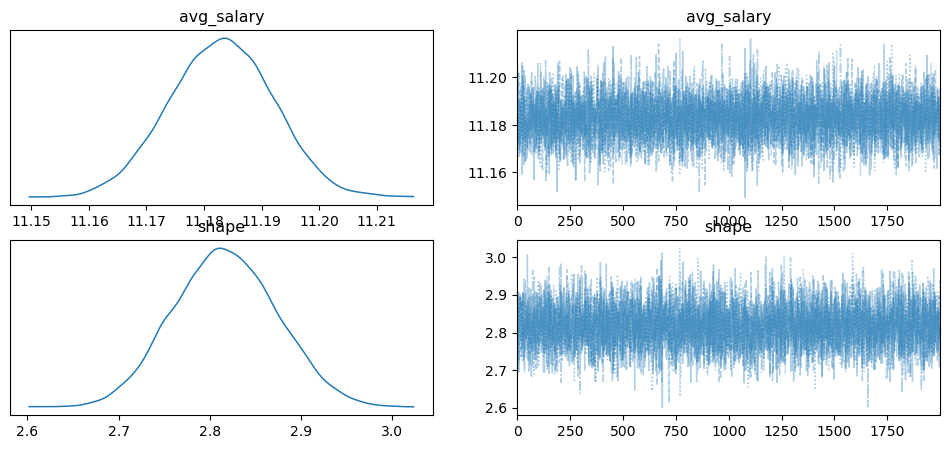

In [113]:
az.plot_trace(trace, combined=True, var_names=["~mu_","~sigma_","~lambda_","~offset_"], filter_vars="like", figsize=(12, 5));

In [114]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [115]:
params2 = {
    'avg_salary_ind': {"type": "intercept", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'exp': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'sex': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'undergrad_edu': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'graduate_edu': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'union': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    # 'part_time': {"type": "slope", "dist": "custom", "initial_values": {"loc": 0, "scale": 1}, "dims": None, "hyperprior": False, "parameterization": "centered"},
    'shape': {"type": "shape", "dist": "uniform", "initial_values": {"low": 0, "high": 100}, "dims": None, "hyperprior": False, "parameterization": "centered"}
}

gamma2 = GammaGML('test', dataset=dataset, parameters=params2, target_var="salary", standardize_vars=["exp","age","tenure"], year=2011)
gamma2

Model: test - params: ['avg_salary_ind', 'shape'] - year: 2011

In [116]:
model2 = gamma2.build(last_trace=trace)

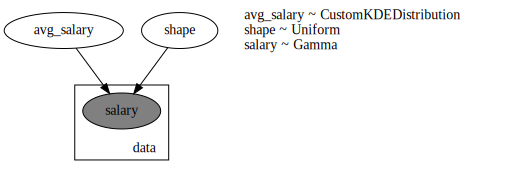

In [117]:
numpyro.render_model(model2, render_distributions=True)

In [118]:
trace2 = gamma2.run_model(model2, warmup=10000, draws=10000)

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu_', 'sigma_', 'lambda_', 'offset_'] have not been found and will be ignored
  warnings.warn(


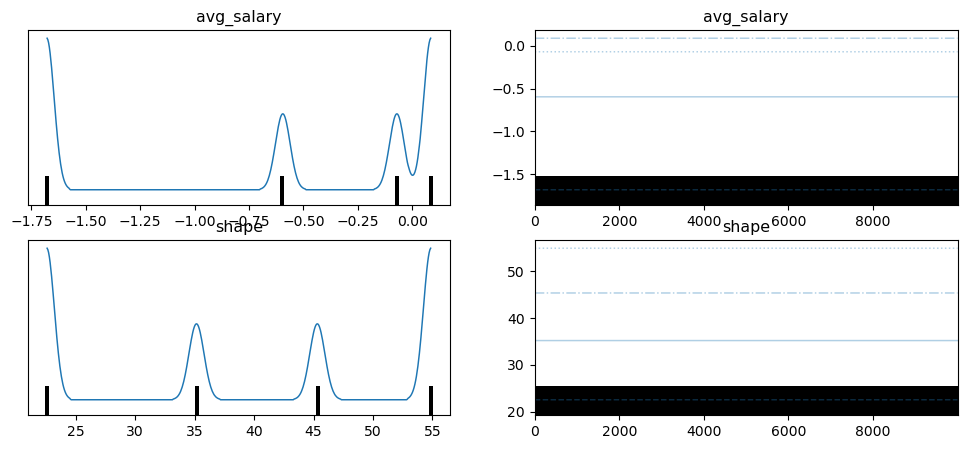

In [104]:
az.plot_trace(trace2, combined=True, var_names=["~mu_","~sigma_","~lambda_","~offset_"], filter_vars="like", figsize=(12, 5));

<Axes: ylabel='Density'>

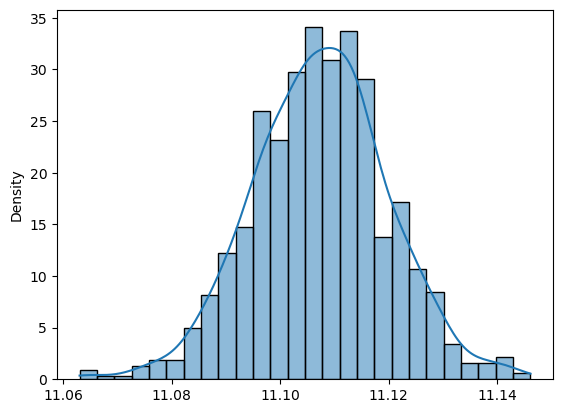

In [48]:
import jax
key = jax.random.PRNGKey(0)
dist_test = CustomKDEDistribution(data=trace.posterior["avg_salary"].values)
a = dist_test.sample(key, (1000,))
sns.histplot(a, kde=True, stat="density")

In [29]:
az.summary(trace, var_names=["~mu_","~sigma_"], filter_vars="like").to_csv("summary_lasso.csv")

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/utils.py:134: UserWarning: Items starting with ~: ['mu_', 'sigma_'] have not been found and will be ignored
  warnings.warn(


In [119]:
dataset = data[data["year"]==2011][["year","industry","elementary_edu","highschool_edu","postsec_edu","undergrad_edu","graduate_edu","exp","salary"]].copy()

In [120]:
dataset.industry = dataset.industry.astype("category")

In [121]:
# Standardize exp
dataset.exp = (dataset.exp - dataset.exp.mean()) / dataset.exp.std()
dataset.exp

917      1.040478
918      0.220954
919      0.384859
924     -0.024903
925      0.139001
           ...   
87013   -1.172237
87014   -0.844427
87015    0.712668
87016   -1.336141
87017   -1.336141
Name: exp, Length: 4515, dtype: float64

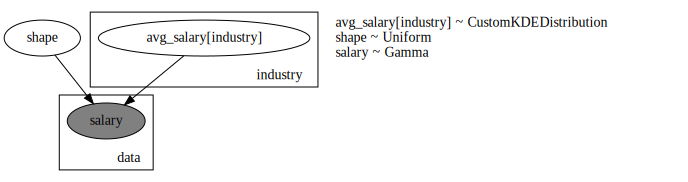

In [122]:
def test():
    with numpyro.plate("industry", len(dataset.industry.unique())):
        avg_salary = numpyro.sample("avg_salary[industry]", CustomKDEDistribution(data=trace.posterior["avg_salary"].values))
        # exp = numpyro.sample("exp", dist.Normal(loc=0, scale=1))
        # elementary_edu = numpyro.sample("elementary_edu", dist.Normal(loc=0, scale=1))
        # highschool_edu = numpyro.sample("highschool_edu", dist.Normal(loc=0, scale=1))
        # postsec_edu = numpyro.sample("postsec_edu", dist.Normal(loc=0, scale=1))
        # undergrad_edu = numpyro.sample("undergrad_edu", dist.Normal(loc=0, scale=1))
        # graduate_edu = numpyro.sample("graduate_edu", dist.Normal(loc=0, scale=1))

    mu = jnp.exp(avg_salary[dataset.industry.cat.codes.values]) #+ exp[dataset.industry.cat.codes.values] * dataset.exp.values +\
        # elementary_edu[dataset.industry.cat.codes.values] * dataset.elementary_edu.values +\
        # highschool_edu[dataset.industry.cat.codes.values] * dataset.highschool_edu.values +\
        # postsec_edu[dataset.industry.cat.codes.values] * dataset.postsec_edu.values +\
        # undergrad_edu[dataset.industry.cat.codes.values] * dataset.undergrad_edu.values +\
        # graduate_edu[dataset.industry.cat.codes.values] * dataset.graduate_edu.values)
    
    shape = numpyro.sample("shape", dist.Uniform(low=0, high=100))
    rate = shape / mu

    with numpyro.plate("data", len(dataset)):
        numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=dataset.salary.values)

numpyro.render_model(test, render_distributions=True)

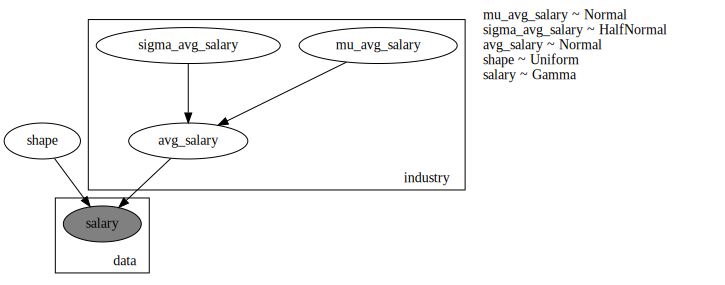

In [23]:
def test_hyper():
    with numpyro.plate("industry", len(dataset.industry.unique())):
        mu_avg_salary = numpyro.sample("mu_avg_salary", dist.Normal(loc=0, scale=1))
        sigma_avg_salary = numpyro.sample("sigma_avg_salary", dist.HalfNormal(scale=1))
        avg_salary = numpyro.sample("avg_salary", dist.Normal(loc=mu_avg_salary, scale=sigma_avg_salary))
        mu = jnp.exp(avg_salary[dataset.industry.cat.codes.values])
    
    shape = numpyro.sample("shape", dist.Uniform(low=0, high=100))
    rate = shape / mu

    with numpyro.plate("data", len(dataset)):
        numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=dataset.salary.values)

numpyro.render_model(test_hyper, render_distributions=True)

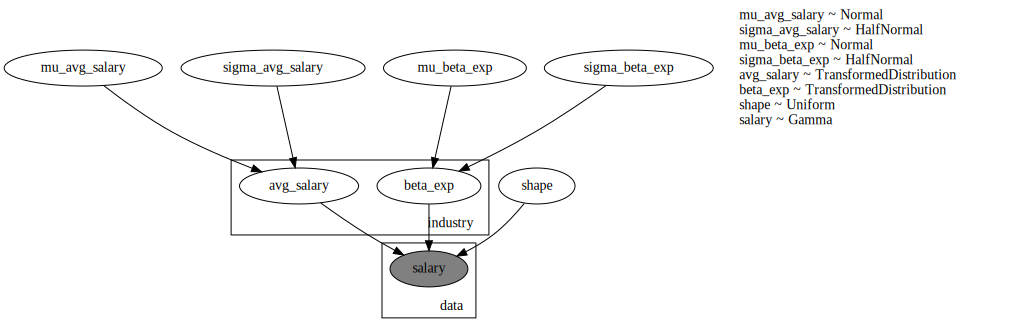

In [78]:
def test_hyper_nc():
    mu_avg_salary = numpyro.sample("mu_avg_salary", dist.Normal(loc=0, scale=1))
    sigma_avg_salary = numpyro.sample("sigma_avg_salary", dist.HalfNormal(scale=1))
    mu_beta_exp = numpyro.sample("mu_beta_exp", dist.Normal(loc=0, scale=1))
    sigma_beta_exp = numpyro.sample("sigma_beta_exp", dist.HalfNormal(scale=1))

    with numpyro.plate("industry", len(dataset.industry.unique())):
        avg_salary = numpyro.sample("avg_salary", dist.TransformedDistribution(dist.Normal(loc=0, scale=1),
                                                                    dist.transforms.AffineTransform(loc=mu_avg_salary, scale=sigma_avg_salary)))
        
        beta_exp = numpyro.sample("beta_exp", dist.TransformedDistribution(dist.Normal(loc=0, scale=1),
                                                                    dist.transforms.AffineTransform(loc=mu_beta_exp, scale=sigma_beta_exp)))
        
        mu = jnp.exp(avg_salary[dataset.industry.cat.codes.values] + beta_exp[dataset.industry.cat.codes.values] * dataset.exp.values)
    
    shape = numpyro.sample("shape", dist.Uniform(low=0, high=100))
    rate = shape / mu

    with numpyro.plate("data", len(dataset)):
        numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=dataset.salary.values)

numpyro.render_model(test_hyper_nc, render_distributions=True)

In [123]:
def run_model(model, draws=4000, warmup=4000, chains=4, target_accept_prob=0.95, postprocess_fn=None, progress_bar=True):
        # Start from this source of randomness. We will split keys for subsequent operations.
        rng_key = random.PRNGKey(0)
        rng_key, rng_key_ = random.split(rng_key)

        # Run NUTS
        kernel = NUTS(model, target_accept_prob=target_accept_prob)
        mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=progress_bar)
        mcmc.run(rng_key)
        trace = az.from_numpyro(mcmc)
        return trace

trace = run_model(test)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


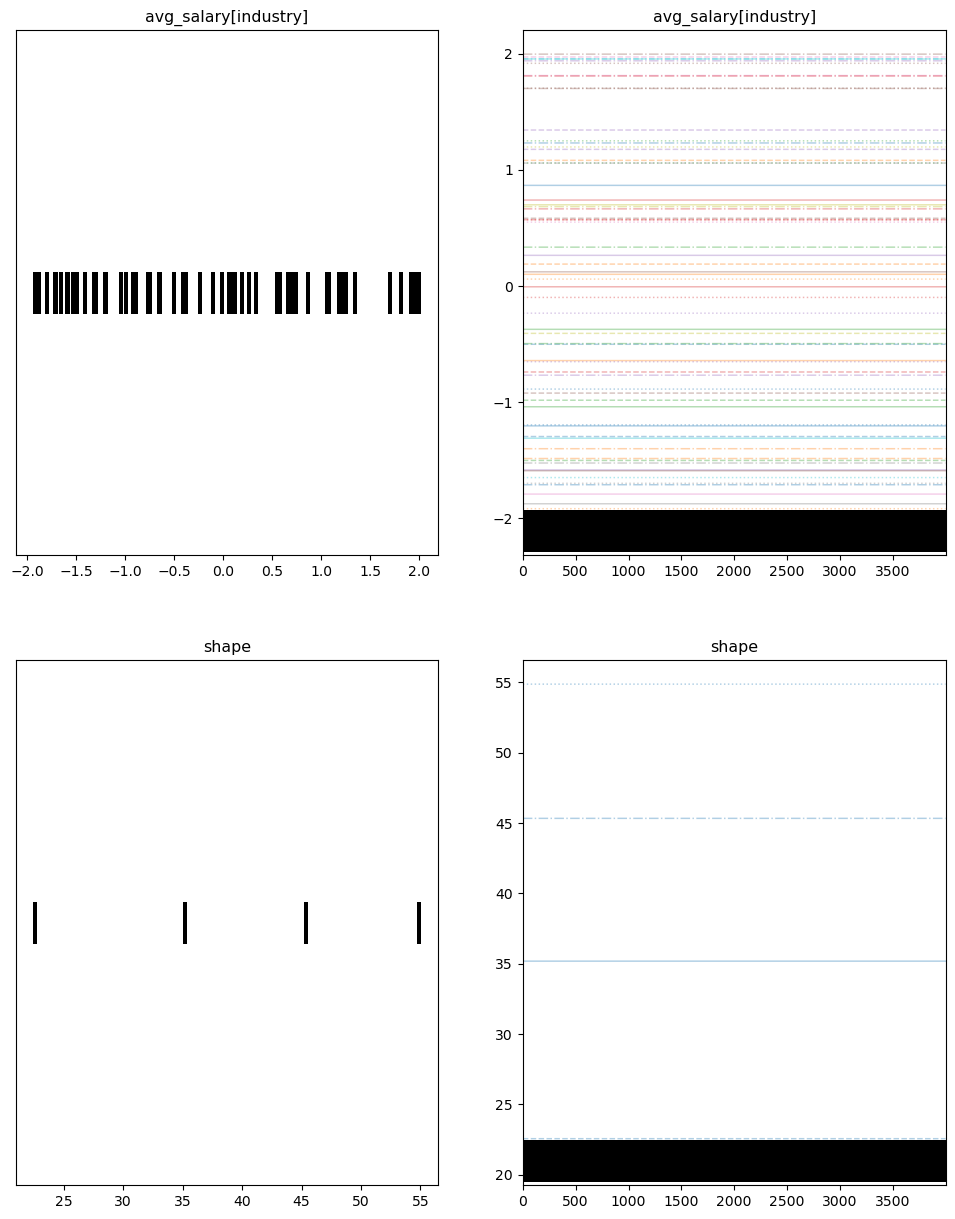

In [124]:
az.plot_trace(trace, filter_vars="like", figsize=(12, 15));

In [53]:
az.summary(trace, filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_salary[industry][0],10.317,0.039,10.243,10.388,0.0,0.0,23946.0,13089.0,1.0
avg_salary[industry][1],10.606,0.062,10.490,10.724,0.0,0.0,35307.0,12595.0,1.0
avg_salary[industry][2],10.788,0.049,10.700,10.883,0.0,0.0,30582.0,12381.0,1.0
avg_salary[industry][3],10.950,0.031,10.888,11.005,0.0,0.0,33022.0,10866.0,1.0
avg_salary[industry][4],11.173,0.024,11.129,11.217,0.0,0.0,32614.0,12750.0,1.0
avg_salary[industry][5],11.048,0.029,10.994,11.102,0.0,0.0,36102.0,10916.0,1.0
avg_salary[industry][6],11.492,0.058,11.384,11.604,0.0,0.0,29759.0,12586.0,1.0
avg_salary[industry][7],10.893,0.020,10.853,10.930,0.0,0.0,30927.0,11642.0,1.0
avg_salary[industry][8],11.047,0.034,10.983,11.108,0.0,0.0,34637.0,11462.0,1.0
avg_salary[industry][9],11.125,0.015,11.099,11.154,0.0,0.0,33333.0,12224.0,1.0


In [244]:
dataset.occup.cat.codes.values

array([8, 9, 2, ..., 7, 8, 7], dtype=int8)

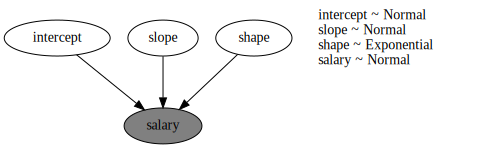

In [245]:
def test():
    intercept = numpyro.sample("intercept", dist.Normal(10, 1), sample_shape=(len(dataset.industry.unique()),))
    slope = numpyro.sample("slope", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()),))

    mu = intercept[dataset.industry.cat.codes.values] + slope[dataset.industry.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test, render_distributions=True)

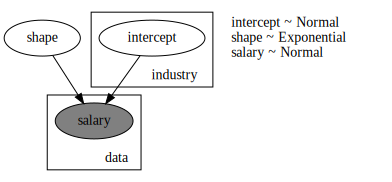

In [246]:
def test_plate():
    with numpyro.plate("industry", len(dataset.industry.unique())):
        intercept = numpyro.sample("intercept", dist.Normal(0, 1))
        # slope = numpyro.sample("slope", dist.Normal(0, 1))

    mu = intercept[dataset.industry.cat.codes.values] #+ slope[dataset.industry.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    with numpyro.plate("data", len(dataset)):
        numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_plate, render_distributions=True)

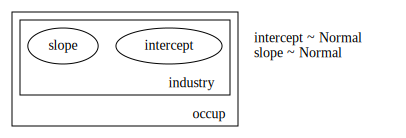

In [301]:
def test_nested_plate():
    with numpyro.plate("occup", len(dataset.occup.unique())), numpyro.plate("industry", len(dataset.industry.unique())):
            intercept = numpyro.sample("intercept", dist.Normal(0, 1))
            slope = numpyro.sample("slope", dist.Normal(0, 1))

    #         mu = intercept[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] + slope[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] * dataset.exp.values

    # sigma = numpyro.sample("shape", dist.Exponential(1))

    # numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_nested_plate, render_distributions=True)

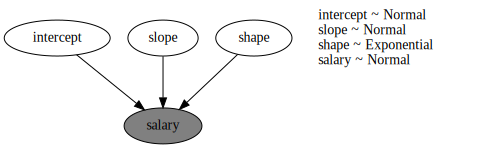

In [358]:
def test_nested():
    intercept = numpyro.sample("intercept", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()), len(dataset.occup.unique())))
    slope = numpyro.sample("slope", dist.Normal(0, 1), sample_shape=(len(dataset.industry.unique()), len(dataset.occup.unique())))

    mu = intercept[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] + slope[dataset.industry.cat.codes.values, dataset.occup.cat.codes.values] * dataset.exp.values

    sigma = numpyro.sample("shape", dist.Exponential(1))

    numpyro.sample("salary", dist.Normal(mu, sigma), obs=dataset.salary.values)

numpyro.render_model(test_nested, render_distributions=True)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

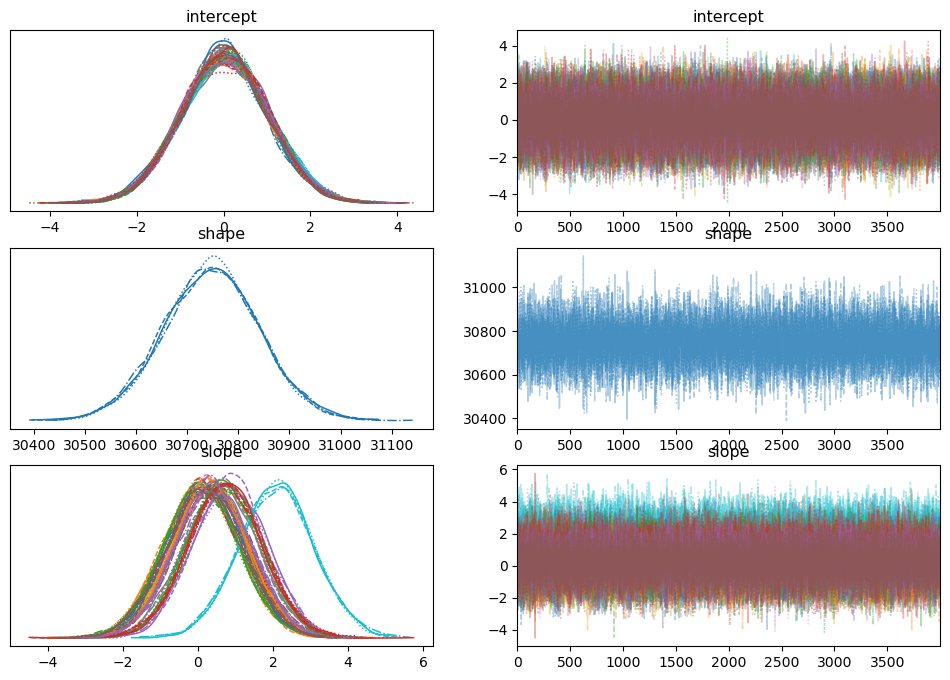

In [60]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_plate = az.from_numpyro(mcmc)
az.plot_trace(trace, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

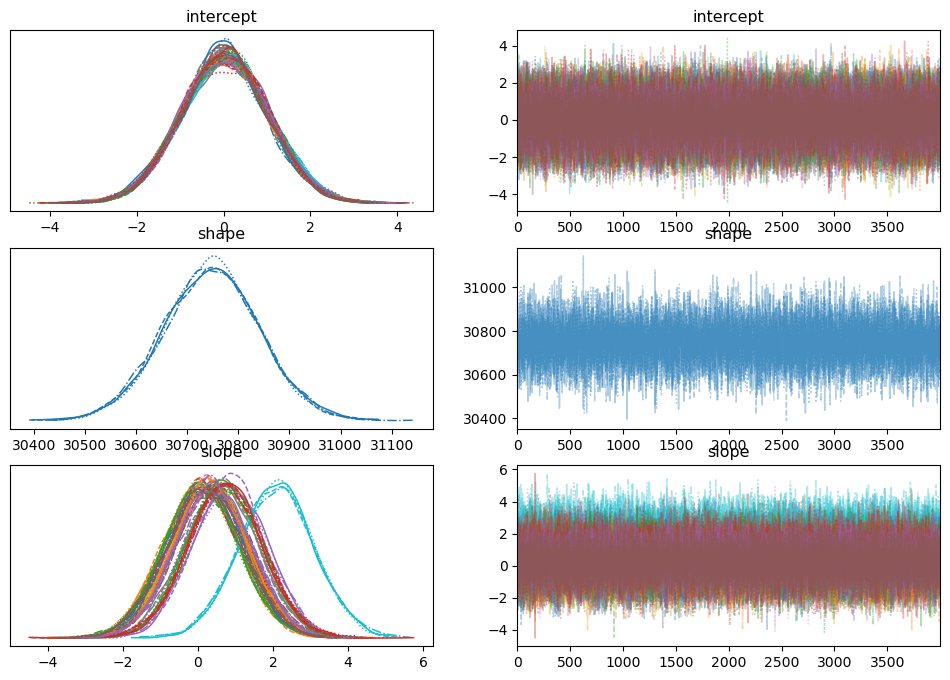

In [61]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_plate, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_plate = az.from_numpyro(mcmc)
az.plot_trace(trace_plate, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

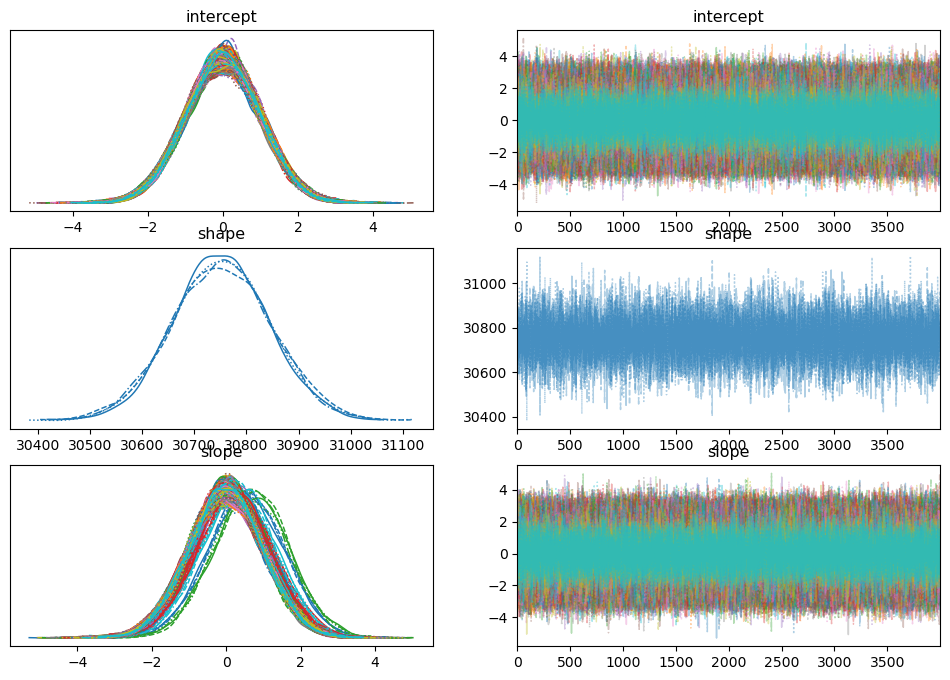

In [84]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_nested_plate, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_nested_plate = az.from_numpyro(mcmc)
az.plot_trace(trace_nested_plate, figsize=(12, 8));

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

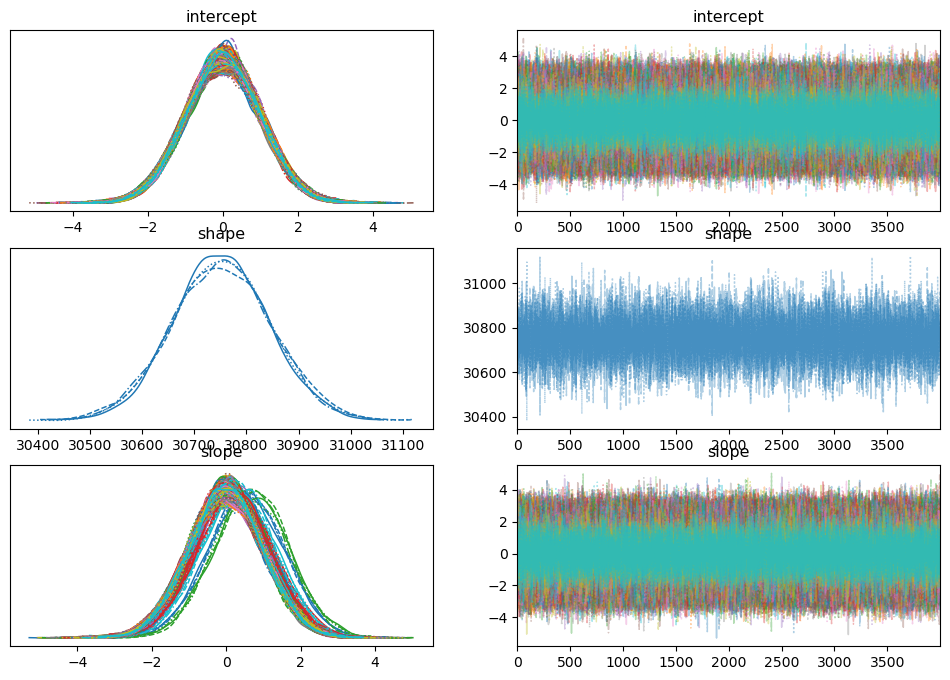

In [85]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(test_nested, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=4000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)
trace_nested = az.from_numpyro(mcmc)
az.plot_trace(trace_nested, figsize=(12, 8));

In [86]:
az.summary(trace_nested_plate).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"intercept[0, 0]",0.012,0.988,-1.805,1.936,0.005,0.009,44827.0,11117.0,1.0
"intercept[0, 1]",-0.001,1.006,-1.893,1.852,0.005,0.010,40616.0,10659.0,1.0
"intercept[0, 2]",0.010,1.013,-1.853,1.952,0.005,0.010,42472.0,10600.0,1.0
"intercept[0, 3]",-0.001,1.004,-1.922,1.835,0.005,0.010,42412.0,11069.0,1.0
"intercept[0, 4]",0.004,0.987,-1.827,1.857,0.005,0.010,39464.0,10357.0,1.0
"intercept[0, 5]",-0.005,1.001,-1.854,1.914,0.005,0.010,41871.0,10820.0,1.0
"intercept[0, 6]",-0.007,1.000,-1.926,1.844,0.005,0.010,41179.0,11035.0,1.0
"intercept[0, 7]",-0.007,0.991,-1.835,1.897,0.005,0.009,37735.0,10888.0,1.0
"intercept[0, 8]",0.013,1.003,-1.888,1.846,0.005,0.010,40485.0,10114.0,1.0
"intercept[0, 9]",0.002,1.003,-1.849,1.907,0.005,0.010,46605.0,11088.0,1.0


In [87]:
az.summary(trace_nested).head(20)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"intercept[0, 0]",0.012,0.988,-1.805,1.936,0.005,0.009,44827.0,11117.0,1.0
"intercept[0, 1]",-0.001,1.006,-1.893,1.852,0.005,0.010,40616.0,10659.0,1.0
"intercept[0, 2]",0.010,1.013,-1.853,1.952,0.005,0.010,42472.0,10600.0,1.0
"intercept[0, 3]",-0.001,1.004,-1.922,1.835,0.005,0.010,42412.0,11069.0,1.0
"intercept[0, 4]",0.004,0.987,-1.827,1.857,0.005,0.010,39464.0,10357.0,1.0
"intercept[0, 5]",-0.005,1.001,-1.854,1.914,0.005,0.010,41871.0,10820.0,1.0
"intercept[0, 6]",-0.007,1.000,-1.926,1.844,0.005,0.010,41179.0,11035.0,1.0
"intercept[0, 7]",-0.007,0.991,-1.835,1.897,0.005,0.009,37735.0,10888.0,1.0
"intercept[0, 8]",0.013,1.003,-1.888,1.846,0.005,0.010,40485.0,10114.0,1.0
"intercept[0, 9]",0.002,1.003,-1.849,1.907,0.005,0.010,46605.0,11088.0,1.0


In [134]:
def model(industry, occupation, experience, salary):
    # Assuming industry and occupation are integer indices
    num_industries = len(set(industry))
    num_occupations = len(set(occupation))
    
    # Priors for the intercept and slope parameters, 
    # with a dimension for each industry and occupation
    with numpyro.plate('industry_occupation_plate', num_industries * num_occupations):
        intercept = numpyro.sample('intercept', dist.Normal(0, 1))
        slope = numpyro.sample('slope', dist.Normal(0, 1))
    
    # Prior for the standard deviation of the residuals
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    
    # Creating an index that represents each combination of industry and occupation
    industry_occupation_index = industry * num_occupations + occupation
    
    # Expected value according to the linear regression model
    mu = intercept[industry_occupation_index] + slope[industry_occupation_index] * experience
    
    # Likelihood of the observed data
    with numpyro.plate('data', len(experience)):
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=salary)


In [135]:
numpyro.render_model(model(dataset.industry.values, dataset.postsec_edu.values, dataset.exp.values, dataset.salary.values), render_distributions=True)

AssertionError: 

In [43]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [261]:
a.data_processing(dataset, standardize_vars=["exp"], categorical_vars=["industry"])

In [262]:
a.dataset[a.target]

array([164249.34152766,  46537.31343284,  17109.30640913, ...,
        43747.44897959,  25850.76530612,  13256.80272109])

In [263]:
a.run_model("test", a.dataset, a.target)

intercept {'exp': {'prior': 'normal', 'initial_values': {'loc': 0, 'scale': 1}, 'dims': None}}
slope {'age': {'prior': 'normal', 'initial_values': {'loc': 0, 'scale': 1}, 'dims': None}}
error {'sigma': {'prior': 'halfnormal', 'initial_values': {'scale': 1}, 'dims': None}}


NameError: name 'exp' is not defined

In [235]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS
kernel = NUTS(a.build())
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='parallel', progress_bar=True)
mcmc.run(rng_key)

intercept {'exp': {'prior': 'normal', 'initial_values': {'mu': 0, 'sigma': 1}, 'dims': None}}
['loc', 'scale']


TypeError: Normal.__init__() got an unexpected keyword argument 'reparametrized_params'

In [61]:
a.prior("intercept", "edu", params["intercept"]["edu"])

AssertionError: 

In [48]:
a.data_processing(dataset, year=2011, standardize_vars=["exp"], categorical_vars=["industry","postsec_edu"])

NameError: name 'dataset' is not defined

In [10]:
b.reparametrized_params

[10, 'scale']

In [9]:
b.reparametrized_params[0] = 10

In [367]:
dataset.query("year == 2011")

,year,industry,postsec_edu,exp,salary
917,2011,public administration,1,31.0,87547.836938
918,2011,transportation and warehousing,1,21.0,100517.886855
919,2011,health care and social assistance,1,23.0,59662.229617
924,2011,health care and social assistance,1,18.0,55771.214642
925,2011,manufacturing,0,20.0,103760.399334
...,...,...,...,...,...
87013,2011,construction,0,4.0,81062.811980
87014,2011,health care and social assistance,0,8.0,74577.787022
87015,2011,construction,1,27.0,214005.823627
87016,2011,trade,1,2.0,11997.296173


In [82]:
np.unique(a.dataset.year)

array([2011])

In [24]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}

In [25]:
def create_model_arrays(dataset: pd.DataFrame, standardize_vars: list=[]):
    model_array = {}
    for col_name, col_data in dataset.select_dtypes(include=["object"]).items():
        model_array[col_name] = {}
        model_array[col_name]["data"] = jnp.array(pd.factorize(col_data)[0])
        model_array[col_name]["cats"] = list(pd.factorize(col_data)[1])
    
    for col_name, col_data in dataset.select_dtypes(include=["int64", "float64"]).items():
        model_array[col_name] = {}
        if col_name in standardize_vars:
            model_array[col_name]["data"] = jnp.array((col_data - col_data.mean()) / col_data.std())
            model_array[col_name]["cats"] = None
        else:
            model_array[col_name]["data"] = jnp.array(col_data)
            model_array[col_name]["cats"] = None
    
    return model_array   

In [101]:
def build_model(model_name, dataset, dependent_var):
    model_array = create_model_arrays(dataset, standardize_vars=["exp", "age", "tenure"])
    
    # Priors
    shape = numpyro.sample("shape", dist.Exponential(1))
    avg_salary_ind = numpyro.sample("avg_salary_ind", dist.Normal(10, 1), sample_shape=(len(model_array["industry"]["cats"]),))
    # avg_salary_occ = numpyro.sample("avg_salary_occ", dist.Normal(10, 1), sample_shape=(len(model_array["occup"]["cats"]),))

    print(avg_salary_ind)

    slopes = []
    data = []
    for col_name, col_data in model_array.items():
        if col_name not in ["industry", "occup", dependent_var]:
            if "_edu" in col_name:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.HalfNormal(1)))
            else:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.Normal(0, 1)))
                
            data.append(col_data["data"])

    slopes = jnp.array(slopes)
    data = jnp.array(data)

    # Expected value (mu)
    # mu = avg_salary_ind[model_array["industry"]["data"]] + avg_salary_occ[model_array["occup"]["data"]] + jnp.dot(slopes, data)
    mu = avg_salary_ind[model_array["industry"]["data"]] + jnp.dot(slopes, data)
    mu = jnp.exp(mu)
    print(mu)
    rate = shape / mu

    # Likelihood
    numpyro.sample(dependent_var, dist.Gamma(concentration=shape, rate=rate), obs=model_array[dependent_var]["data"])

In [102]:
def postprocess_trace(trace):
    trace = trace.copy()
    for var_name, var_data in trace.posterior.data_vars.items():
        if var_name in ["avg_salary_ind", "avg_salary_occ"]:
            trace.posterior[var_name].values[:] = np.exp(var_data)
        elif var_name not in ["shape"]:
            # Get relative values (%)
            trace.posterior[var_name].values[:] = np.exp(var_data) - 1
            # # Get absolute values ($)
            # trace.posterior[var_name].values[:] = (np.exp(var_data) - 1) * (trace.posterior["avg_salary_ind"][:, :] * trace.posterior["avg_salary_occ"][:, :]) 
    return trace

In [103]:
def run_model(model_name, dataset, dependent_var, draws=2000, warmup=2000, chains=4, target_accept_prob=0.95, postprocess_fn=None):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS
    kernel = NUTS(build_model, target_accept_prob=target_accept_prob)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=True)
    mcmc.run(rng_key, model_name, dataset, dependent_var)
    trace = az.from_numpyro(mcmc)
    updated_trace = postprocess_trace(trace)
    updated_trace.to_netcdf(f"traces/{model_name}.nc")
    return trace

In [104]:
# parameters = ["exp","sex",{"edu_level":['elementary_edu','highschool_edu','postsec_edu','undergrad_edu','graduate_edu']},
#     {"grad_refyear":['grad_highschool_refyear','grad_college_refyear','grad_univ_refyear']},'tenure','union','part_time',
#     'public_sector','self_emp',{"firm_size":['firm_size','loc_size']},'age']

parameters = ["exp",'age']

columns = ['salary','industry']
for id_run, param in enumerate(parameters):
    # Append param to columns
    if isinstance(param, dict):
        columns += list(param.values())[0]
    else:
        columns.append(param)

    if id_run == 0:
        model_name = f"M{id_run}-{param}"
    elif isinstance(param, dict):
        model_name = f"M{id_run}-M{id_run-1}+{list(param.keys())[0]}"
    else:
        model_name = f"M{id_run}-M{id_run-1}+{param}"

    trace = run_model(model_name=model_name, dataset=dataset[columns], dependent_var="salary", draws=2000, warmup=2000, chains=4)
                                # target_accept_prob=0.95, postprocess_fn=None)
    print(f"Run {id_run} completed") 

NameError: name 'create_model_arrays' is not defined

In [34]:
trace

NameError: name 'trace' is not defined

In [ ]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}
def create_model_arrays(dataset: pd.DataFrame, standardize_vars: list=[]):
    model_array = {}
    for col_name, col_data in dataset.select_dtypes(include=["object"]).items():
        model_array[col_name] = {}
        model_array[col_name]["data"] = jnp.array(pd.factorize(col_data)[0])
        model_array[col_name]["cats"] = list(pd.factorize(col_data)[1])
    
    for col_name, col_data in dataset.select_dtypes(include=["int64", "float64"]).items():
        model_array[col_name] = {}
        if col_name in standardize_vars:
            model_array[col_name]["data"] = jnp.array((col_data - col_data.mean()) / col_data.std())
            model_array[col_name]["cats"] = None
        else:
            model_array[col_name]["data"] = jnp.array(col_data)
            model_array[col_name]["cats"] = None
    
    return model_array   
def build_model(model_name, dataset, dependent_var):
    model_array = create_model_arrays(dataset, standardize_vars=["exp", "age", "tenure"])
    
    # Priors
    shape = numpyro.sample("shape", dist.Exponential(1))
    avg_salary_ind = numpyro.sample("avg_salary_ind", dist.Normal(10, 1), sample_shape=(len(model_array["industry"]["cats"]),))
    avg_salary_occ = numpyro.sample("avg_salary_occ", dist.Normal(10, 1), sample_shape=(len(model_array["occup"]["cats"]),))

    slopes = []
    data = []
    for col_name, col_data in model_array.items():
        if col_name not in ["industry", "occup", dependent_var]:
            if "_edu" in col_name:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.HalfNormal(1)))
            else:
                slopes.append(numpyro.sample(f"beta_{col_name}", dist.Normal(0, 1)))
                
            data.append(col_data["data"])

    slopes = jnp.array(slopes)
    data = jnp.array(data)

    # Expected value (mu)
    mu = avg_salary_ind[model_array["industry"]["data"]] + avg_salary_occ[model_array["occup"]["data"]] + jnp.dot(slopes, data)
    mu = jnp.exp(mu)
    rate = shape / mu

    # Likelihood
    numpyro.sample(dependent_var, dist.Gamma(concentration=shape, rate=rate), obs=model_array[dependent_var]["data"])
def postprocess_trace(trace):
    trace = trace.copy()
    for var_name, var_data in trace.posterior.data_vars.items():
        if var_name in ["avg_salary_ind", "avg_salary_occ"]:
            trace.posterior[var_name].values[:] = np.exp(var_data)
        elif var_name not in ["shape"]:
            # Get relative values (%)
            trace.posterior[var_name].values[:] = np.exp(var_data) - 1
            # # Get absolute values ($)
            # trace.posterior[var_name].values[:] = (np.exp(var_data) - 1) * (trace.posterior["avg_salary_ind"][:, :] * trace.posterior["avg_salary_occ"][:, :]) 
    return trace
def run_model(model_name, dataset, dependent_var, draws=2000, warmup=2000, chains=4, target_accept_prob=0.95, postprocess_fn=None):
    # Start from this source of randomness. We will split keys for subsequent operations.
    rng_key = random.PRNGKey(0)
    rng_key, rng_key_ = random.split(rng_key)

    # Run NUTS
    kernel = NUTS(build_model, target_accept_prob=target_accept_prob)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=draws, num_chains=chains, chain_method='parallel', postprocess_fn=postprocess_fn, progress_bar=False)
    mcmc.run(rng_key, model_name, dataset, dependent_var)
    trace = az.from_numpyro(mcmc)
    updated_trace = postprocess_trace(trace)
    updated_trace.to_netcdf(f"traces/{model_name}.nc")
    return trace

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

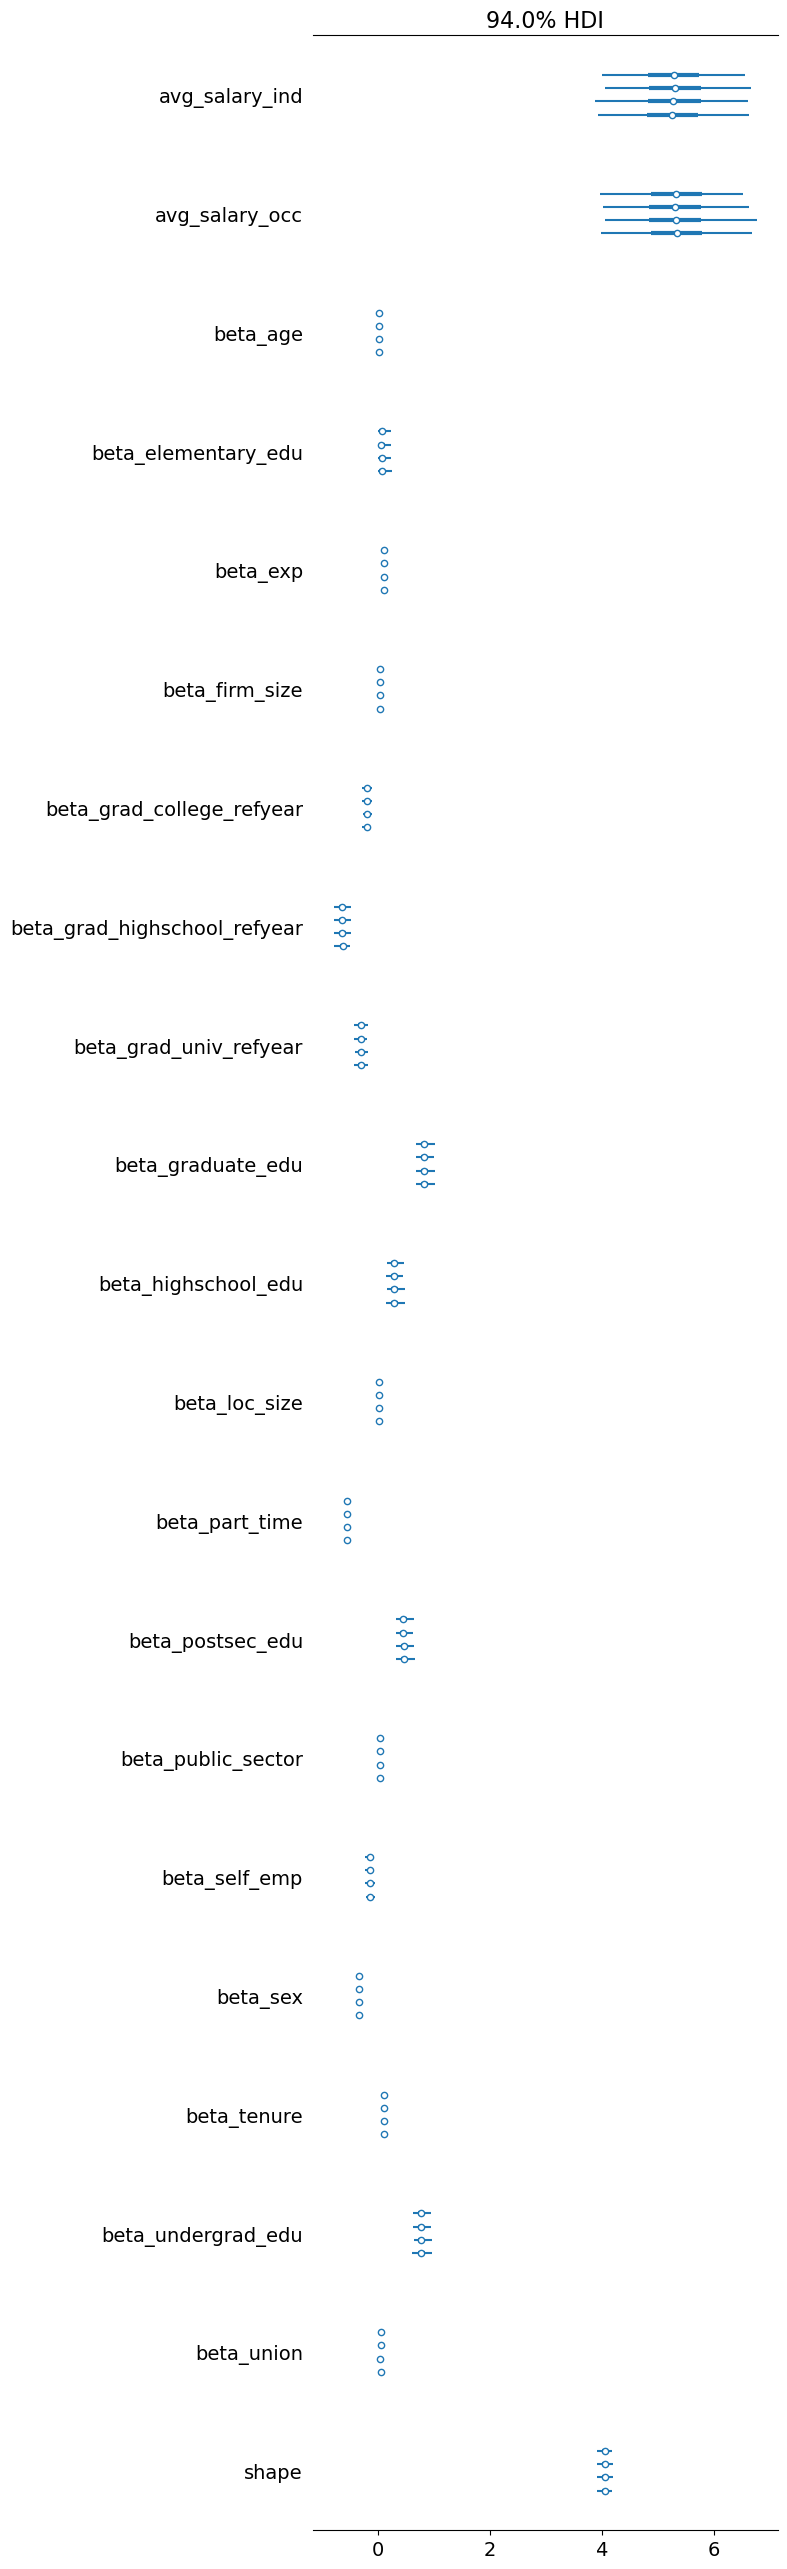

In [45]:
az.plot_forest(trace)

#TODO:
1. Run backward elimination (adding the log calculation) using a for loop
2. Plotting the famous chart to see if adding variables is relevant
3. Run the model with the variables selected but updating the priors

In [281]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
avg_salary_ind,5.276,0.698,3.930,6.585,0.010,0.007,4946.0,5164.0,1.0
avg_salary_occ,5.312,0.697,3.980,6.622,0.010,0.007,4853.0,5214.0,1.0
beta_age,0.020,0.013,-0.002,0.045,0.000,0.000,5710.0,5474.0,1.0
beta_elementary_edu,0.092,0.080,0.000,0.242,0.002,0.001,2185.0,3213.0,1.0
beta_exp,0.110,0.013,0.085,0.133,0.000,0.000,5677.0,5464.0,1.0
beta_firm_size,0.041,0.006,0.031,0.052,0.000,0.000,9246.0,5939.0,1.0
beta_grad_college_refyear,-0.192,0.045,-0.272,-0.102,0.000,0.000,9857.0,6221.0,1.0
beta_grad_highschool_refyear,-0.627,0.078,-0.781,-0.485,0.001,0.001,9460.0,6047.0,1.0
beta_grad_univ_refyear,-0.299,0.066,-0.421,-0.177,0.001,0.001,8599.0,6062.0,1.0
beta_graduate_edu,0.837,0.092,0.680,1.014,0.002,0.001,2278.0,3264.0,1.0


# Test model

In [15]:
data.shape

(5475, 47)

In [7]:
ind_idx, ind_cats = pd.factorize(data["industry"])
occup_idx, occup_cats = pd.factorize(data["occup"])
exp_idx = jnp.array(data["exp"].values)

elementary_edu_idx = jnp.array(data["elementary_edu"].values)
highschool_edu_idx = jnp.array(data["highschool_edu"].values)
postsec_edu_idx = jnp.array(data["postsec_edu"].values)
undergrad_edu_idx = jnp.array(data["undergrad_edu"].values)
graduate_edu_idx = jnp.array(data["graduate_edu"].values)

grad_highschool_refyear_idx = jnp.array(data["grad_highschool_refyear"].values)
grad_college_refyear_idx = jnp.array(data["grad_college_refyear"].values)
grad_univ_refyear_idx = jnp.array(data["grad_univ_refyear"].values)

public_sector_idx = jnp.array(data["public_sector"].values)
self_emp_idx = jnp.array(data["self_emp"].values)
union_idx = jnp.array(data["union"].values)
part_time_idx = jnp.array(data["part_time"].values)

tenure_idx = jnp.array(data["tenure"].values)
age_idx = jnp.array(data["age"].values)
firm_size_idx = jnp.array(data["firm_size"].values)
loc_size_idx = jnp.array(data["loc_size"].values)
sex_idx = jnp.array(data["sex"].values)

salary_idx = jnp.array(data["salary"].values)

In [269]:
exp_idx = (exp_idx - exp_idx.mean()) / exp_idx.std()
age_idx = (age_idx - age_idx.mean()) / age_idx.std()
tenure_idx = (tenure_idx - tenure_idx.mean()) / tenure_idx.std()

In [270]:
def model():
    intercept = numpyro.sample("intercept", dist.Normal(10, 1))#, sample_shape=(len(ind_cats),))
    occup = numpyro.sample("occup", dist.Normal(10, 1))#, sample_shape=(len(occup_cats),))
    exp = numpyro.sample("exp", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    elementary_edu = numpyro.sample("elementary_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    highschool_edu = numpyro.sample("highschool_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    postsec_edu = numpyro.sample("postsec_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    undergrad_edu = numpyro.sample("undergrad_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))
    graduate_edu = numpyro.sample("graduate_edu", dist.HalfNormal(1))#, sample_shape=(len(ind_cats),))

    grad_highschool_refyear = numpyro.sample("grad_highschool_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    grad_college_refyear = numpyro.sample("grad_college_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    grad_univ_refyear = numpyro.sample("grad_univ_refyear", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    public_sector = numpyro.sample("public_sector", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    self_emp = numpyro.sample("self_emp", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    union = numpyro.sample("union", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    part_time = numpyro.sample("part_time", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    tenure = numpyro.sample("tenure", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    age = numpyro.sample("age", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    firm_size = numpyro.sample("firm_size", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    loc_size = numpyro.sample("loc_size", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))
    sex = numpyro.sample("sex", dist.Normal(0, 1))#, sample_shape=(len(ind_cats),))

    shape = numpyro.sample("shape", dist.Exponential(1))

    mu = jnp.exp(intercept + occup + exp * exp_idx + elementary_edu * elementary_edu_idx + 
                    highschool_edu * highschool_edu_idx + postsec_edu * postsec_edu_idx + 
                    undergrad_edu * undergrad_edu_idx + graduate_edu * graduate_edu_idx +
                    grad_highschool_refyear * grad_highschool_refyear_idx + grad_college_refyear * grad_college_refyear_idx +
                    grad_univ_refyear * grad_univ_refyear_idx + public_sector * public_sector_idx +
                    self_emp * self_emp_idx + union * union_idx + part_time * part_time_idx +
                    tenure * tenure_idx + age * age_idx + firm_size * firm_size_idx +
                    loc_size * loc_size_idx + sex * sex_idx)
                    
    rate = shape / mu

    numpyro.sample("salary", dist.Gamma(concentration=shape, rate=rate), obs=salary_idx)

In [271]:
def postprocess_samples(samples):
    return {k: jnp.exp(v) for k, v in samples.items()}

In [272]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model, target_accept_prob=0.95)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=2000, num_samples=num_samples, num_chains=4, chain_method='parallel', postprocess_fn=None)
mcmc.run(rng_key)
# mcmc.print_summary()
# samples = mcmc.get_samples()

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [273]:
az.summary(az.from_numpyro(mcmc))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
age,0.020,0.013,-0.004,0.044,0.000,0.000,5129.0,5060.0,1.0
elementary_edu,0.098,0.084,0.000,0.251,0.002,0.001,1768.0,3056.0,1.0
exp,0.109,0.013,0.084,0.133,0.000,0.000,5226.0,5019.0,1.0
firm_size,0.041,0.006,0.030,0.052,0.000,0.000,9431.0,5475.0,1.0
grad_college_refyear,-0.192,0.045,-0.277,-0.107,0.000,0.000,8817.0,5558.0,1.0
grad_highschool_refyear,-0.628,0.079,-0.776,-0.480,0.001,0.001,8294.0,5747.0,1.0
grad_univ_refyear,-0.298,0.066,-0.422,-0.176,0.001,0.000,8724.0,5706.0,1.0
graduate_edu,0.843,0.095,0.685,1.031,0.002,0.002,1860.0,3137.0,1.0
highschool_edu,0.310,0.092,0.150,0.486,0.002,0.002,1804.0,3026.0,1.0
intercept,5.312,0.694,3.990,6.591,0.010,0.007,4440.0,5319.0,1.0


In [ ]:
az.plot_trace(az.from_numpyro(mcmc), var_names=["intercept","occup","exp","elementary_edu","highschool_edu","postsec_edu",
                                                "undergrad_edu","graduate_edu","shape"],combined=True, figsize=(12, 25));

In [171]:
az.plot_trace(trace, var_names=["avg_salary_ind","avg_salary_occ","beta_exp","beta_elementary_edu","beta_highschool_edu",
                                "beta_postsec_edu","beta_undergrad_edu","beta_graduate_edu","beta_grad_highschool_refyear",
                                "beta_grad_college_refyear","beta_grad_univ_refyear","beta_public_sector","beta_self_emp",
                                "beta_union","beta_part_time","beta_tenure","beta_age","beta_firm_size","beta_loc_size",
                                "beta_sex","shape"],combined=True, figsize=(12, 25));

KeyError: 'var names: "[\'beta_elementary_edu\' \'beta_highschool_edu\' \'beta_postsec_edu\'\\n \'beta_undergrad_edu\' \'beta_graduate_edu\' \'beta_grad_highschool_refyear\'\\n \'beta_grad_college_refyear\' \'beta_grad_univ_refyear\' \'beta_public_sector\'\\n \'beta_self_emp\' \'beta_union\' \'beta_part_time\' \'beta_tenure\' \'beta_age\'\\n \'beta_firm_size\' \'beta_loc_size\' \'beta_sex\'] are not present" in dataset'